### LIBRERIAS

In [459]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import pandas as pd

from skimage.measure import shannon_entropy
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cdist
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [460]:
# Función para detectar rostro (Encuentra cara con rectángulo y recorta lo exterior)
def detect_face(img, face_cascade):
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        return img[y:y+h, x:x+w] # Alto y ancho
    return img

# Preprocesamiento con filtro gaussiano
def preprocess_image(img_path, size=(64, 64), apply_blur=True):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Leer imagen en escala de grises
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Recorte de rostro
    img = detect_face(img, face_cascade)
    
    # Aplicar filtro Gaussiano si se desea
    if apply_blur:
        img = cv2.GaussianBlur(img, (3, 3), 0)
    
    # Redimensionar
    img_resized = cv2.resize(img, size)
    
    # Normalizar
    img_normalized = img_resized / 255.0
    
    return img_normalized

In [461]:
# Directorio
dataset = "olivetti_faces_selected"

# Leer las imágenes y etiquetas
images = []
labels = []

# Diccionario para asignar nombres de clase secuenciales
class_to_label = {}
next_label = 0

for filename in os.listdir(dataset):
            
    # Cargar imagen en escala de grises
    img_path = os.path.join(dataset, filename)
    image = preprocess_image(img_path, apply_blur=True)
    
    # Extraer la etiqueta desde el nombre del archivo
    label = int(filename.split("_")[-1].split(".")[0])

    # Asignar nombre
    if label not in class_to_label:
        class_to_label[label] = f"face{next_label}"
        next_label += 1

    # Asignar el nuevo nombre a la etiqueta
    new_label = class_to_label[label]

    images.append(image)
    labels.append(new_label) 

images = np.array(images)
Y = np.array(labels)

def extract_features(image):

    # 1. Intensidad Promedio (Brillo)
    mean_intensity = np.mean(image)

    # 2. Contraste (Desviación Estándar de la Intensidad)
    contrast = np.std(image)

    # 3. Simetría Vertical (Diferencia Promedio entre Mitades)
    h, w = image.shape
    left_side = image[:, :w // 2]
    right_side = np.fliplr(image[:, w // 2:])
    symmetry = np.mean(np.abs(left_side - right_side))

    # 4. Detección de Contornos (Cantidad de Píxeles con Bordes)
    edges = cv2.Canny((image * 255).astype(np.uint8), 100, 200)
    num_contours = np.count_nonzero(edges)

    # 5. Área de la Boca (Cantidad de Píxeles Claros en la Región)
    mouth_roi = image[40:55, 15:45]  
    mouth_area = np.sum(mouth_roi > 0.5)

    # 6. Área de los Ojos (Cantidad de Píxeles Claros en la Región)
    eye_roi = image[15:35, 15:45] 
    eye_area = np.sum(eye_roi > 0.5)

    # 7. Densidad de Bordes (Promedio de Píxeles Detectados por Canny)
    edge_density = np.mean(edges)

    # 8. Entropía de la imagen (Cantidad de información en la imagen)
    entropy = shannon_entropy(image)

    # 9. Proporción de Píxeles Oscuros (Píxeles < 0.2)
    dark_pixel_ratio = np.sum(image < 0.2) / (h * w)

    # 10. Textura (Diferencia Promedio entre Píxeles Vecinos)
    texture = np.mean(np.abs(image[:, :-1] - image[:, 1:]))

    return [mean_intensity, contrast, symmetry, num_contours, mouth_area, eye_area, edge_density, entropy, dark_pixel_ratio, texture]


# Extraer características
X_features = np.array([extract_features(img) for img in images])

# Normalizar los datos (normalización previa a la división)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_features)


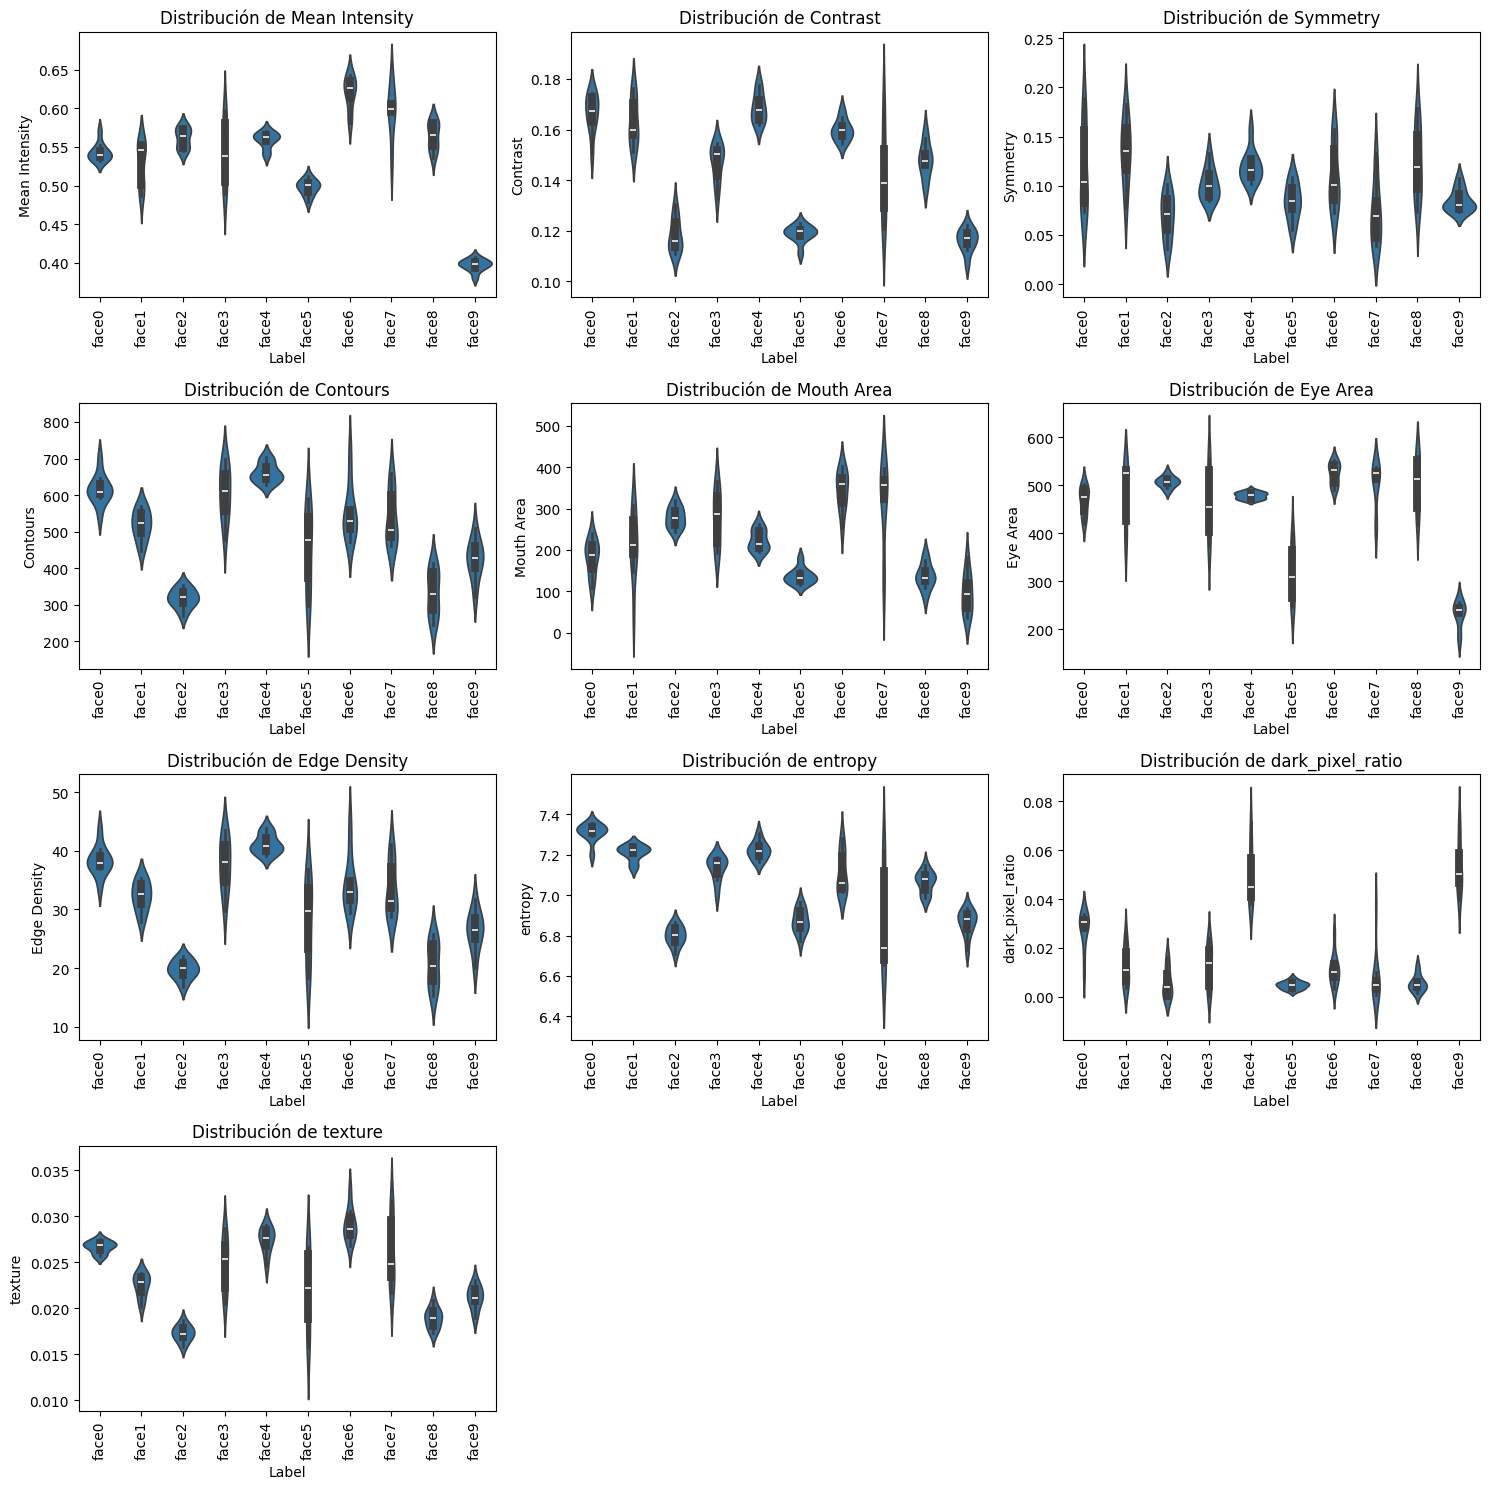

In [462]:
# Convertir las características y las etiquetas a un DataFrame
columns = ['Mean Intensity', 'Contrast', 'Symmetry', 'Contours', 'Mouth Area', 'Eye Area', 
           'Edge Density','entropy','dark_pixel_ratio','texture']

X_df = pd.DataFrame(X_features, columns=columns)

# Agregar las etiquetas (nuevas) al DataFrame
X_df['Label'] = Y

plt.figure(figsize=(15, 15))

# Iterar sobre las características para crear diagramas de violín
for i, column in enumerate(columns):
    plt.subplot(4, 3, i+1) 
    sns.violinplot(data=X_df, x='Label', y=column)
    plt.title(f'Distribución de {column}')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [463]:
# Análisis de gaussianidad por clase y característica
gaussianity_results = []

for label in X_df['Label'].unique():
    subset = X_df[X_df['Label'] == label]
    for feature in columns:
        _, p_value = shapiro(subset[feature])
        gaussianity_results.append({
            'Clase': label,
            'Característica': feature,
            'p-valor': p_value,
            '¿Distribución Normal?': 'Sí' if p_value > 0.05 else 'No'
        })

# Mostrar los resultados en un DataFrame
gauss_df = pd.DataFrame(gaussianity_results)
display(gauss_df)

# Contar cuántas veces "¿Distribución Normal?" es "No"
non_gaussian_count = gauss_df[gauss_df['¿Distribución Normal?'] == 'No'].shape[0]

# Resumen por clase (cuántas características son normales o no)
resumen_gauss = gauss_df.groupby(['Clase', '¿Distribución Normal?']).size().unstack(fill_value=0)
display(resumen_gauss)


,Clase,Característica,p-valor,¿Distribución Normal?
0,face0,Mean Intensity,0.027213,No
1,face0,Contrast,0.134982,Sí
2,face0,Symmetry,0.135680,Sí
3,face0,Contours,0.396115,Sí
4,face0,Mouth Area,0.519131,Sí
...,...,...,...,...
95,face9,Eye Area,0.037960,No
96,face9,Edge Density,0.958207,Sí
97,face9,entropy,0.165818,Sí
98,face9,dark_pixel_ratio,0.329362,Sí


¿Distribución Normal?,No,Sí
Clase,,
face0,3,7
face1,3,7
face2,0,10
face3,1,9
face4,1,9
face5,1,9
face6,1,9
face7,4,6
face8,1,9


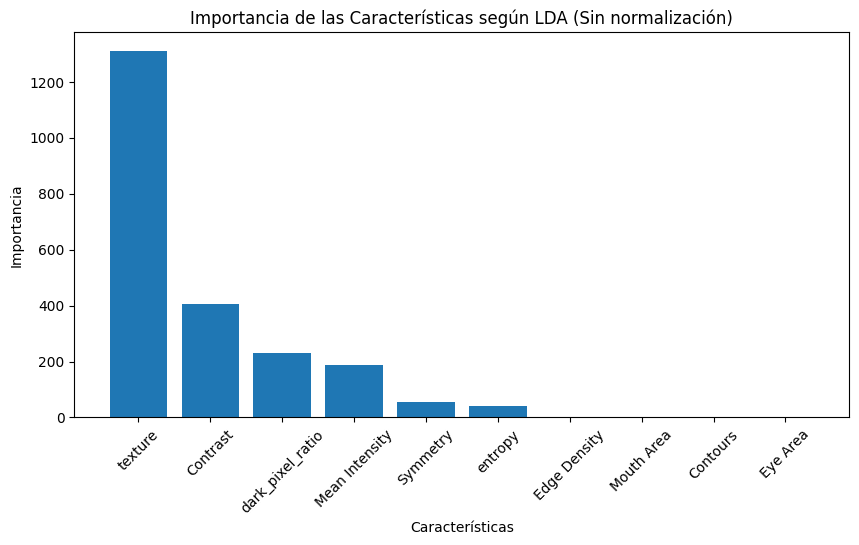

In [464]:
# Aplicar LDA para analizar la importancia de las características
lda = LinearDiscriminantAnalysis()
lda.fit(X_features, Y)

# Obtener la importancia de cada característica en la clasificación
feature_importance = np.abs(lda.coef_).mean(axis=0)

# Ordenar características según su importancia
sorted_indices = np.argsort(feature_importance)[::-1]

# Características en su nombre real
columns = ['Mean Intensity', 'Contrast','Symmetry','Contours', 'Mouth Area', 'Eye Area', 
           'Edge Density', 'entropy','dark_pixel_ratio','texture']

# Mostrar importancia de características
plt.figure(figsize=(10, 5))
plt.bar(np.array(columns)[sorted_indices], feature_importance[sorted_indices])
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.title("Importancia de las Características según LDA (Sin normalización)")
plt.xticks(rotation=45)
plt.show()

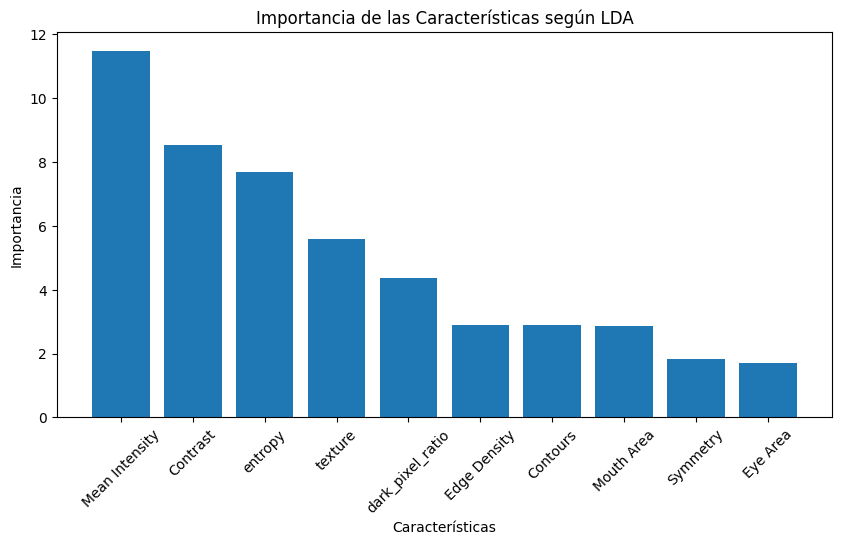

In [465]:
# Aplicar LDA para analizar la importancia de las características
lda = LinearDiscriminantAnalysis()
lda.fit(X_normalized, Y)

# Obtener la importancia de cada característica en la clasificación
feature_importance = np.abs(lda.coef_).mean(axis=0)

# Ordenar características según su importancia
sorted_indices = np.argsort(feature_importance)[::-1]

# Características en su nombre real
columns = ['Mean Intensity', 'Contrast', 'Symmetry','Contours', 'Mouth Area', 'Eye Area', 
           'Edge Density', 'entropy','dark_pixel_ratio','texture']

# Mostrar importancia de características
plt.figure(figsize=(10, 5))
plt.bar(np.array(columns)[sorted_indices], feature_importance[sorted_indices])
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.title("Importancia de las Características según LDA")
plt.xticks(rotation=45)
plt.show()

### Modelos


In [466]:
# Eliminar la característica 
remove = 5

# Eliminar la columna correspondiente de X_normalized
X_normalized = np.delete(X_normalized, remove, axis=1)

# Dividir los datos normalizados en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(X_normalized, Y, test_size=0.2, random_state=42, stratify=Y)

Precisión obtenida: 0.8500
F1-score: 0.8533


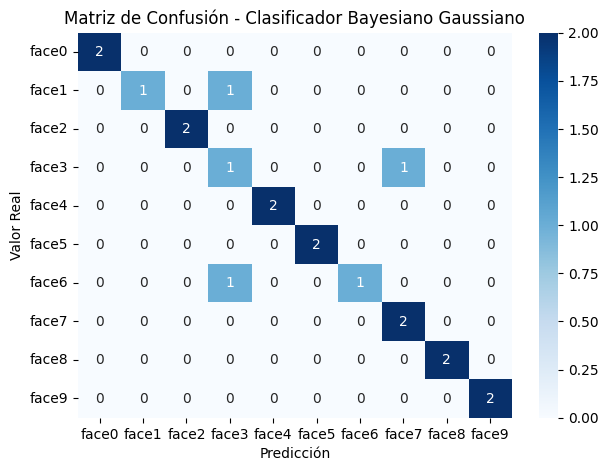


Reporte de Clasificación:
              precision    recall  f1-score   support

       face0       1.00      1.00      1.00         2
       face1       1.00      0.50      0.67         2
       face2       1.00      1.00      1.00         2
       face3       0.33      0.50      0.40         2
       face4       1.00      1.00      1.00         2
       face5       1.00      1.00      1.00         2
       face6       1.00      0.50      0.67         2
       face7       0.67      1.00      0.80         2
       face8       1.00      1.00      1.00         2
       face9       1.00      1.00      1.00         2

    accuracy                           0.85        20
   macro avg       0.90      0.85      0.85        20
weighted avg       0.90      0.85      0.85        20



In [467]:
# Entrenar el clasificador bayesiano gaussiano
gnb = GaussianNB()
gnb.fit(x_train, y_train)

# Hacer predicción
y_pred_nb = gnb.predict(x_test)

# Calcular métricas
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')  
recall_nb = recall_score(y_test, y_pred_nb, average='weighted') 
f1 = f1_score(y_test, y_pred_nb, average='weighted') 

# Imprimir resultado
print(f"Precisión obtenida: {accuracy_nb:.4f}")
print(f"F1-score: {f1:.4f}")

# Graficar la matriz de confusión
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True,  cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - Clasificador Bayesiano Gaussiano")
plt.show()

# Imprimir reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_nb))



Precisión obtenida: 0.9500
F1-score: 0.9467


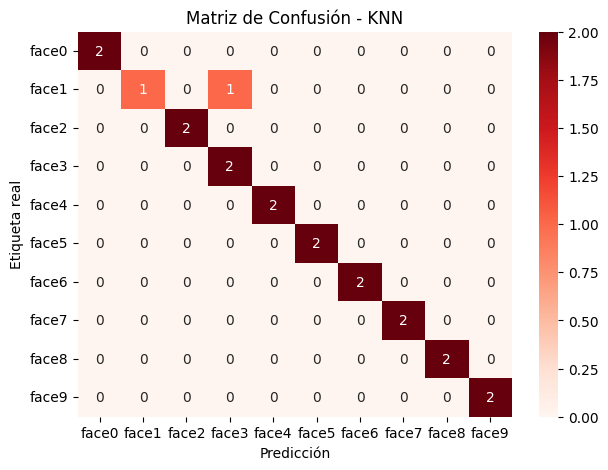


Reporte de Clasificación:
              precision    recall  f1-score   support

       face0       1.00      1.00      1.00         2
       face1       1.00      0.50      0.67         2
       face2       1.00      1.00      1.00         2
       face3       0.67      1.00      0.80         2
       face4       1.00      1.00      1.00         2
       face5       1.00      1.00      1.00         2
       face6       1.00      1.00      1.00         2
       face7       1.00      1.00      1.00         2
       face8       1.00      1.00      1.00         2
       face9       1.00      1.00      1.00         2

    accuracy                           0.95        20
   macro avg       0.97      0.95      0.95        20
weighted avg       0.97      0.95      0.95        20



In [468]:
# Entrenar el modelo con k vecinos
knn_model = KNeighborsClassifier(3, weights='distance')
knn_model.fit(x_train, y_train)

# Hacer predicciones
y_pred_knn = knn_model.predict(x_test)

# Calcular métricas
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')  
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')  
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')  

# Imprimir resultados
print(f"\nPrecisión obtenida: {accuracy_knn:.4f}")
print(f"F1-score: {f1_knn:.4f}")

# Matriz de confusión
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, cmap="Reds", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title(f"Matriz de Confusión - KNN")
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_knn))



Precisión obtenida: 0.9000
F1-score: 0.8933


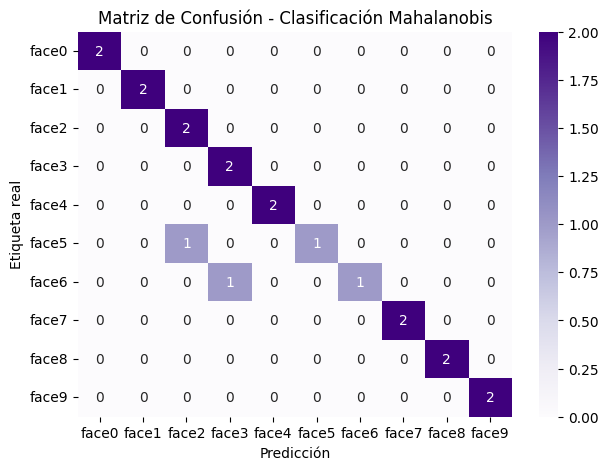


Reporte de Clasificación:
              precision    recall  f1-score   support

       face0       1.00      1.00      1.00         2
       face1       1.00      1.00      1.00         2
       face2       0.67      1.00      0.80         2
       face3       0.67      1.00      0.80         2
       face4       1.00      1.00      1.00         2
       face5       1.00      0.50      0.67         2
       face6       1.00      0.50      0.67         2
       face7       1.00      1.00      1.00         2
       face8       1.00      1.00      1.00         2
       face9       1.00      1.00      1.00         2

    accuracy                           0.90        20
   macro avg       0.93      0.90      0.89        20
weighted avg       0.93      0.90      0.89        20



In [469]:
# Calcular centroides de cada clase
centroids = {}
for label in np.unique(y_train):
    centroids[label] = np.mean(x_train[y_train == label], axis=0)

# Calcular la matriz de covarianza inversa
cov_matrix = np.cov(x_train.T)  
inv_cov_matrix = np.linalg.pinv(cov_matrix) 

# Calcular la distancia de Mahalanobis entre cada muestra de x_test y los centroides
distances = cdist(x_test, np.array(list(centroids.values())), metric='mahalanobis', VI=inv_cov_matrix)

# Obtener la clase con la menor distancia para cada muestra
class_labels = np.array(list(centroids.keys()))  
y_pred_md = class_labels[np.argmin(distances, axis=1)]

# Calcular métricas
accuracy_md = accuracy_score(y_test, y_pred_md)
precision_md = precision_score(y_test, y_pred_md, average='weighted')  
recall_md = recall_score(y_test, y_pred_md, average='weighted')  
f1_md = f1_score(y_test, y_pred_md, average='macro')  

# Imprimir resultados
print(f"\nPrecisión obtenida: {accuracy_md:.4f}")
print(f"F1-score: {f1_md:.4f}")

# Graficar matriz de confusión
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_md), annot=True, cmap="Purples", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - Clasificación Mahalanobis")
plt.show()

# Imprimir reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_md))


F1-score: 1.0000
Precisión obtenida: 1.0000


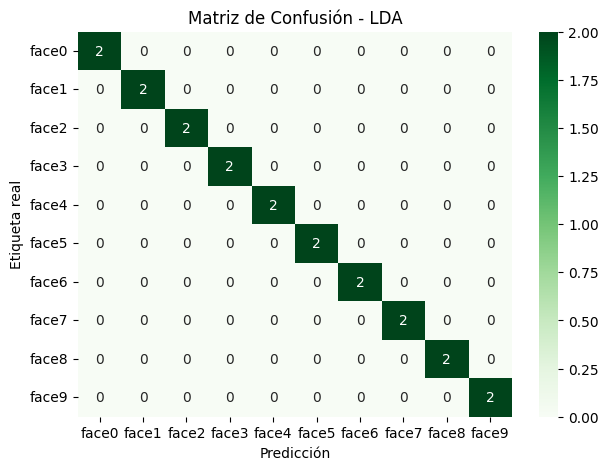


Reporte de Clasificación:
              precision    recall  f1-score   support

       face0       1.00      1.00      1.00         2
       face1       1.00      1.00      1.00         2
       face2       1.00      1.00      1.00         2
       face3       1.00      1.00      1.00         2
       face4       1.00      1.00      1.00         2
       face5       1.00      1.00      1.00         2
       face6       1.00      1.00      1.00         2
       face7       1.00      1.00      1.00         2
       face8       1.00      1.00      1.00         2
       face9       1.00      1.00      1.00         2

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [470]:
# Entrenar el clasificador LDA
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

# Predicción en el conjunto de prueba
y_pred = lda.predict(x_test)

# Evaluación del modelo
accuracy_lda = accuracy_score(y_test, y_pred)
precision_lda = precision_score(y_test, y_pred, average='weighted')  
recall_lda = recall_score(y_test, y_pred, average='weighted')  
f1_lda = f1_score(y_test, y_pred, average='weighted')  

# Imprimir precisión
print(f"F1-score: {f1_lda:.4f}")
print(f"Precisión obtenida: {accuracy_lda:.4f}")

# Graficar la matriz de confusión
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Greens", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - LDA")
plt.show()

# Imprimir reporte de clasificación (incluye F1-score)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


In [471]:
# Crear un diccionario con los valores
data = {
    "Clasificador": ["Bayesiano Gaussiano", "KNN", "Mínima Distancia (Mahalanobis)", "LDA"],
    "Accuracy": [accuracy_nb, accuracy_knn, accuracy_md, accuracy_lda],
    "Precision": [precision_nb, precision_knn, precision_md, precision_lda],
    "Recall": [recall_nb, recall_knn, recall_md, recall_lda],
    "F1-score": [f1, f1_knn, f1_md, f1_lda]
}

# Crear DataFrame
df = pd.DataFrame(data)

# Imprimir tabla
print(df.to_string(index=False))


                  Clasificador  Accuracy  Precision  Recall  F1-score
           Bayesiano Gaussiano      0.85   0.900000    0.85  0.853333
                           KNN      0.95   0.966667    0.95  0.946667
Mínima Distancia (Mahalanobis)      0.90   0.933333    0.90  0.893333
                           LDA      1.00   1.000000    1.00  1.000000
